In [1]:
import numpy as np
import numba
from numba import njit

# The Barnes-Hut algorithm

*Disclaimer: This method uses Python classes, which cannot be used with numba just-in-time compilation. This makes it seem slow. Much more efficient implementations are possible but make however the simplicity of the algorithm much less obvious. Therefore the following code is not meant to be used in production. Note that algorithmically similar object-oriented implementations are possible in compiled languages such as C++ or Fortran without similar performance penality.*

## Description of the algorithm
*see lecture notes for details, this is just a summary*

The Barnes-Hut algorithm approximates the direct summation between particles (which scales as $\mathcal{O}(N^2)$ in the total number of particles $N$) with a summation between particles and groups of particles (which scales as $\mathcal{O}(N \log N)$ under relatively mild assumptions). The algorithm is based on the observation that the gravitational force between a particle and a distant group of particles is very well approximated by a multipole expansion of the group.

In the method, the simulation domain is recursively partitioned into octants ('octs', in 3D) or quadrants ('quads' in 2D) until each octant contains at most a certain number of particles. Inside of each oct or quad a multipole expansion is computed. When computing the interaction between a particle and all other particles, the algorithm proceeds from the root node of the tree downward, checking if the multipole expansion of a node is good enough to approximate the interaction, otherwise it descends to the children nodes. The criterion for a good approximation is that the distance between the particle and the center of mass of the node is larger than a certain threshold, which is usually taken to be a multiple of the size of the node. This threshold is called the opening angle.

## Function to partition a group of particles into 8 octants relative to a center point


In [2]:
@njit
def partition_sort( points, imin, imax, center ):
    """
    Partition the particles in the range [imin, imax) into 8 octants based on their position
    relative to the given center. The function sorts the particles in-place so that particles
    belonging to the same octant are contiguous, and returns the number of particles in each
    octant and the offsets for each octant in the sorted array.

    Parameters
    ----------
    points : ndarray
      Array of shape (N, 3) containing the positions of the particles.
    imin : int
      Start index of the range to partition (inclusive).
    imax : int
      End index of the range to partition (exclusive).
    center : ndarray
      Array of shape (3,) representing the center used to partition the space.

    Returns
    -------
    points_in_oct : ndarray
      Array of shape (8,) containing the number of particles in each octant.
    points_in_oct_offsets : ndarray
      Array of shape (9,) containing the offsets for each octant in the sorted array.
    """
    # sort particles in range imin...imax into quads
    nodepoints = points[imin:imax]
    partition_idx = (nodepoints[:,2] > center[2])*4\
                  + (nodepoints[:,1] > center[1])*2 \
                  + (nodepoints[:,0] > center[0])
    partition_order = np.argsort(partition_idx)
    points[imin:imax,:] = nodepoints[partition_order,:]
    
    # compute how many particles in each quad
    points_in_oct = np.zeros(8,dtype=numba.int64)
    for oct_id in partition_idx:
        points_in_oct[oct_id] += 1
        
    # compute offsets
    points_in_oct_offsets = np.zeros(9,dtype=numba.int64)
    points_in_oct_offsets[1:] = np.cumsum(points_in_oct)
    points_in_oct_offsets += imin # get the offset in the global array
    
    return points_in_oct, points_in_oct_offsets

## Functions to compute multipole moments (to quadrupole order) and evaluate the multipole expansion given an interaction point and a set of multipole moments

In [3]:
@njit
def compute_multipoles( points, imin, imax, center ):
    """
    Compute the monopole, dipole, and quadrupole moments of a group of particles
    relative to a given center.

    Parameters
    ----------
    points : ndarray
      Array of shape (N, 3) containing the positions of the particles.
    imin : int
      Start index of the range to compute moments (inclusive).
    imax : int
      End index of the range to compute moments (exclusive).
    center : ndarray
      Array of shape (3,) representing the center relative to which moments are computed.

    Returns
    -------
    M : float
      Monopole moment (total mass, assuming unit mass per particle).
    D : ndarray
      Dipole moment (shape (3,)).
    Q : ndarray
      Quadrupole moment (shape (3,3)).
    """
    M = 0.0
    D = np.zeros(3)
    Q = np.zeros((3,3))
    for i in range(imin,imax):
        d = points[i,:] - center
        M += 1.0
        D += d
        Q += 3 * np.outer(d,d) - np.eye(3) * np.dot(d,d)
    return M,D,Q

@njit
def evaluate_multipoles( multipoles, dvec, d ):
    """
    Evaluate the multipole expansion (monopole, dipole, quadrupole) at a given point.

    Parameters
    ----------
    multipoles : tuple
      Tuple containing (M, D, Q): monopole (float), dipole (ndarray shape (3,)), quadrupole (ndarray shape (3,3)).
    dvec : ndarray
      Displacement vector from the multipole expansion center to the evaluation point (shape (3,)).
    d : float
      Distance from the multipole expansion center to the evaluation point.

    Returns
    -------
    potential : float
      The potential at the evaluation point due to the multipole expansion.
    """
    M, D, Q = multipoles
    # monopole
    potential = M / d 
    # dipole
    potential += np.dot(D,dvec) / d**3
    # quadrupole
    potential += 0.5 * np.dot(dvec,np.dot(Q,dvec)) / d**5
    return -potential

## Helper function to compute direct interaction sum

In [4]:
@njit 
def potential_directsum( points, i, j0, jN ):
    """
    Compute the gravitational potential at a given point due to a set of other points
    using direct summation.

    Parameters
    ----------
    points : ndarray
      Array of shape (N, 3) containing the positions of the particles.
    i : int
      Index of the evaluation point.
    j0 : int
      Start index of the source points (inclusive).
    jN : int
      End index of the source points (exclusive).

    Returns
    -------
    potential : float
      The gravitational potential at point i due to all points in the range [j0, jN).
    """
    potential = 0.0
    for j in range(j0,jN):
        dvec = points[i,:] - points[j,:]
        d = np.sqrt(dvec@dvec)
        if d > 1e-10:
            potential += -1.0 / d
    return potential

# Main function implementing an Octree-Node that partitions the given particles by recursively calling itself thus generating the tree structure

In [5]:
class OctreeNode:
  """
  OctreeNode class for the Barnes-Hut algorithm.

  This class represents a node in an octree structure used to efficiently compute
  gravitational potentials using the Barnes-Hut approximation. Each node can recursively
  partition its region into 8 octants, compute multipole moments for its particles,
  and evaluate the potential at a given point using either the multipole expansion
  or by descending into child nodes as needed for accuracy.

  Attributes
  ----------
  corner : ndarray
    The coordinates of the lower corner of the node's cubic region.
  length : float
    The edge length of the node's cubic region.
  center : ndarray
    The geometric center of the node's cubic region.
  size : int
    The number of particles contained in the node.
  range : tuple
    The (imin, imax) indices of the particles in the node.
  level : int
    The refinement level of the node in the tree.
  children : dict
    Dictionary mapping octant indices to child OctreeNode instances.
  multipoles : tuple
    The multipole moments (monopole, dipole, quadrupole) of the node's particles.

  Methods
  -------
  __init__(points, imin, imax, corner, length, level=0)
    Initializes the node, computes multipoles, and partitions if needed.
  partition(points)
    Partitions the node's particles into 8 octants and creates child nodes.
  potential(points, theta, i)
    Evaluates the gravitational potential at a given point using the Barnes-Hut criterion.
  """
  def __init__( self, points, imin, imax, corner, length, level=0 ):
      """
      Initialize an OctreeNode.

      Parameters
      ----------
      points : ndarray
          Array of particle positions.
      imin : int
          Starting index of particles in this node.
      imax : int
          Ending index (exclusive) of particles in this node.
      corner : ndarray
          Coordinates of the lower corner of the node's cubic region.
      length : float
          Edge length of the node's cubic region.
      level : int, optional
          Refinement level of the node in the tree (default is 0).
      """
      # corner coordinates of this node
      self.corner = corner
      # edge length of this node
      self.length = length
      # geometric center of this node (used as split point)
      self.center = self.corner + self.length/2
      # number of particles in the node
      self.size   = imax-imin   
      # range of particle indices that are inside this node
      self.range  = (imin,imax) 
      # refinement level of this node
      self.level  = level        
      # dictionary of children
      self.children = {}
      
      # multipoles
      self.multipoles  = compute_multipoles( points, imin, imax, self.center )
      
      # if more than 1 (could be more) particles in the node, then 
      # recursively split (partition) the node into children
      if self.size > 1:
          self.partition( points )

  def partition( self, points ):
      """
      Partition the node's particles into 8 octants and create child nodes.

      Parameters
      ----------
      points : ndarray
        Array of particle positions.

      This method sorts the particles in the node into 8 octants based on their
      position relative to the node's center, then creates a child OctreeNode
      for each non-empty octant.
      """
      # sort into quads and store number in each of the quads in nquads and 
      # the offsets for each quad in nquadoff
      nq,nqoff = partition_sort( points, self.range[0], 
                                self.range[1], self.center )
      
      for i in range(2):
        for j in range(2):
          for k in range(2):
            oct_id = k*4+j*2+i
            if nq[oct_id] > 0: # if particles in quad, create new node
                newlength = self.length/2
                newcorner = self.corner + np.array((i,j,k)) * newlength
                
                self.children[oct_id] = \
                  OctreeNode( points, nqoff[oct_id], nqoff[oct_id+1],
                                newcorner, newlength, self.level+1 )
                  

  def potential( self, points, theta, i ):
      """
      Evaluate the gravitational potential at a given point using the Barnes-Hut criterion.

      Parameters
      ----------
      points : ndarray
        Array of particle positions.
      theta : float
        Opening angle parameter for the Barnes-Hut criterion.
      i : int
        Index of the point at which to evaluate the potential.

      Returns
      -------
      potential : float
        The computed gravitational potential at the specified point.
      """
      # vector from evaluation to pivot
      dvec = points[i,:]-self.center
      # distance evaluation to pivot
      d = np.linalg.norm(dvec)
      # diagonal size of node
      rl = 0.86602540378 * self.length  # sqrt(3)/2 * edge length of node
      if rl / d < theta: # node passes accuracy criterion
          potential = evaluate_multipoles( self.multipoles, dvec, d )
      else: # need to go to children nodes to reduce error
          if len(self.children)>0 : # if there are any, do so
              potential = 0.0
              for c in self.children.values():
                  potential += c.potential( points, theta, i )
          else: 
              # if there aren't any, direct sum of particles in node
              # i.e. compute the exact interaction of particles in self.range
              # with particle i
              potential = potential_directsum( points, i, \
                              self.range[0], self.range[1] )
      return potential

## Test problem and validation of accuracy

In [6]:
# generate a number of 3D Gaussian distributed points, they should fit into [0,1]^3, as we assume that as the bounding volume for the octree construction

N = 10000
np.random.seed(0)
X = np.random.normal(size=(N,3), loc=0.5, scale=0.1)

# Generate the octree recursivley by calling the constructor on the root node
ot = OctreeNode(X, 0, N, np.zeros(3), 1.0)

# compute the potential at each point using the octree
theta = 0.7
phi = np.array([ot.potential( X, theta, i ) for i in range(N)])

# for testing purposes, compute the potential using direct summation
phi_direct = np.array([potential_directsum( X, i, 0, N ) for i in range(N)])

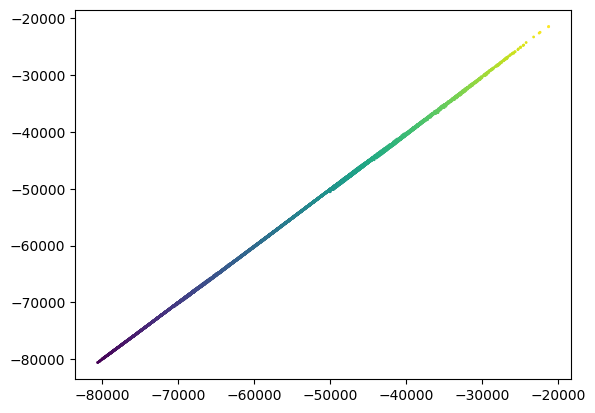

In [7]:
# plot the BH tree potential vs the direct sum potential

import matplotlib.pyplot as plt
plt.scatter(phi, phi_direct,c=phi, s=1);

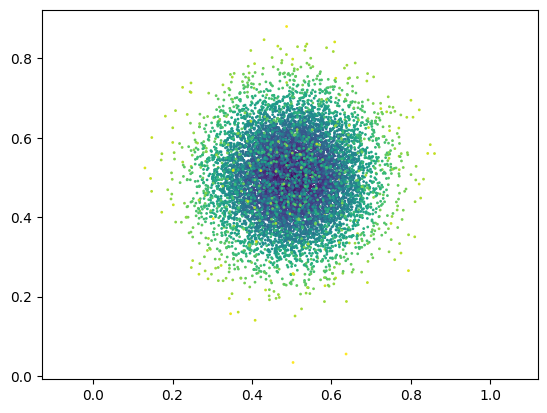

In [8]:
# create a scatter plot of the points colored by the potential
plt.scatter(X[:,0],X[:,1],c=phi, s=1)
plt.axis('equal');